In [1]:
import numpy as np
import matplotlib.pyplot as plt
import niceplots as nicepl
from scipy.stats import gaussian_kde

In [2]:
# pip install ..///

In [3]:
nicepl.initPlot()

In [21]:
# load data
chain=np.load("posterior_blind_0.npz")['samples']
weights=np.load("posterior_blind_0.npz")['weights']
weights=np.exp(weights)

In [22]:
Nparams=chain.shape[1]

In [23]:
param_names=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]

priors={
    r"$\theta_1$": [0.64, 1.035],
    r"$\theta_2$": [0.23008603805291986, 0.39969071100893877],
    r"$\theta_3$": [-1.5, 1.5],
}

In [24]:
def add_contour(ax, x, y, priorsX, priorsY, color='k', probs=np.array([0.68, 0.95, 0.997]), alpha_min=0.1, alpha_max=0.8):
    
    # 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
            
    # Grid for evaluation
    xgrid = np.linspace(priorsX[0], priorsX[1], 100)
    ygrid = np.linspace(priorsY[0], priorsY[1], 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Compute contour levels for 1σ, 2σ, 3σ
    Z_flat = Z.flatten()
    Z_sorted = np.sort(Z_flat)[::-1]
    dz = (xgrid[1] - xgrid[0]) * (ygrid[1] - ygrid[0])  # grid area element
    cumsum = np.cumsum(Z_sorted*dz)
    cumsum /= cumsum[-1]

    levels = []
    for p in probs:
        idx = np.searchsorted(cumsum, p)
        levels.append(Z_sorted[idx])

    levels=sorted(levels)
            
    alphas = np.linspace(alpha_min, alpha_max, len(levels))

    # Plot from outermost to innermost
    for k in range(len(levels)):
        high=Z.max()
        low=levels[k]
        ax.contourf(X, Y, Z, levels=[low, high], colors=color, alpha=alphas[k])

In [25]:
def add_hist(ax, x, priorsX, color='k', alpha=1.0):
    # 1D KDE
    kde = gaussian_kde(x)
    
    # Grid for evaluation
    xgrid = np.linspace(priorsX[0], priorsX[1], 100)
    Z = kde(xgrid)

    # Compute contour levels for 1σ, 2σ, 3σ
    Z_flat = Z.flatten()
    Z_sorted = np.sort(Z_flat)[::-1]
    dz = (xgrid[1] - xgrid[0])  # grid area element
    cumsum = np.cumsum(Z_sorted*dz)
    cumsum /= cumsum[-1]

    ax.plot(xgrid, Z, color=color, alpha=alpha)

In [26]:
from matplotlib.patches import Patch

In [27]:
def add_chain(axs, chain, param_names, priors, lower_triangle=True, color='k', 
              probs=np.array([0.68, 0.95, 0.997]), alpha_min=0.1, alpha_max=0.8,
              label=None):
    Nparams=chain.shape[1]

    for i in range(Nparams):
        y=chain[:,i]
        y_par_name=param_names[i]
        y_prior=priors[y_par_name]

        for j in range(Nparams):
            x=chain[:,j]
            x_par_name=param_names[j]
            x_prior=priors[x_par_name]

            # Do plots
            if i == j:
                add_hist(axs[i, j], y, y_prior, color=color, alpha=alpha_min+alpha_max)
            elif (i>j and lower_triangle) or (i<j and not lower_triangle):
                add_contour(axs[i, j], x, y, x_prior, y_prior, color=color, probs=probs, alpha_min=alpha_min, alpha_max=alpha_max)


    if label is not None:
        patch=Patch(color=color, label=label)
        return patch

In [28]:
def hide_unused_axes(axs, lower_triangle=True):
    Nparams = len(axs)
    for i in range(Nparams):
        for j in range(Nparams):
            if i < j and lower_triangle:
                axs[i, j].axis("off")
            elif i > j and not lower_triangle:
                axs[i, j].axis("off")


In [29]:
def prep_plot(param_names, priors):
    Nparams=len(param_names)

    fig, axs=plt.subplots(Nparams, Nparams)

    plt.subplots_adjust(hspace=0.0, wspace=0.0)

    for i in range(Nparams):
        y_par_name=param_names[i]
        y_prior=priors[y_par_name]

        for j in range(Nparams):
            x_par_name=param_names[j]
            x_prior=priors[x_par_name]
            
            # Set axis limits
            axs[i, j].set_xlim(x_prior[0], x_prior[1])
            
            if i!=j:
                axs[i, j].set_ylim(y_prior[0], y_prior[1])

            # Set axis labels
            if (i==Nparams-1):
                axs[i, j].set_xlabel(x_par_name)
            else:
                axs[i, j].set_xticklabels([])

            if (j==0) and  (i!=0):
                axs[i, j].set_ylabel(y_par_name)
            else:
                axs[i, j].set_yticklabels([])

    return fig, axs

In [30]:
# color='C0'

# fig, axs=prep_plot(param_names, priors)


# # Add the chain
# handles=[]
# handles.append(add_chain(axs, chain, param_names, priors, lower_triangle=True, 
#                          color='C0', probs=np.array([0.68, 0.95, 0.997]), 
#                          alpha_min=0.1, alpha_max=0.8, label='Chain 1'))
# handles.append(add_chain(axs, chain, param_names, priors, lower_triangle=True, 
#                          color='C1', probs=np.array([0.68, 0.95, 0.997]), 
#                          alpha_min=0.1, alpha_max=0.8, label="Chain 2"))

# # Remove None handles (if label=None)
# handles = [h for h in handles if h is not None]
# fig.legend(handles=handles, labels=[h.get_label() for h in handles])

# hide_unused_axes(axs, lower_triangle=True)

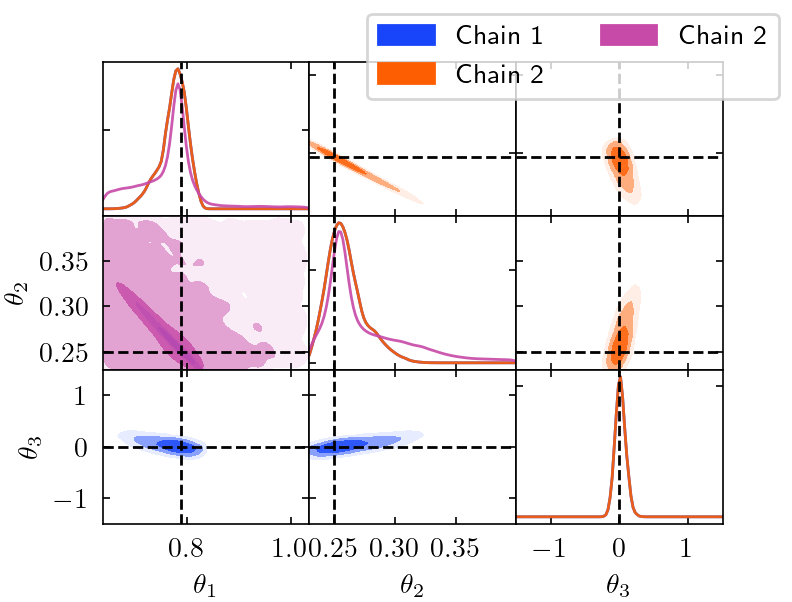

In [31]:
c=nicepl.corner(param_names, priors)
c.add_chain(chain, param_names, weights, color='C0', label="Chain 1")
c.add_chain(chain, param_names, weights, lower_triangle=False, color='C1', label="Chain 2")
c.add_chain(chain[:,:2], param_names[:2], weights=np.ones(chain.shape[0]), color='C3', label="Chain 2")

c.add_truth(r"$\theta_1$", 0.79)
c.add_truth(r"$\theta_2$", 0.25)
c.add_truth(r"$\theta_3$", 0.0)
c.add_truth(r"$\theta_2$", 0.25, lower_triangle=False)
c.add_truth(r"$\theta_3$", 0.0, lower_triangle=False)
c.add_truth(r"$\theta_1$", 0.79, lower_triangle=False)



c.finalize(hide_upper=False, outputFn="test.pdf", legendcols=2)